## Assignment 2 - ANLY 601
### Name: Yunjia Zeng
### NetID: yz682

### Question 2: Kernel Regression
#### Part 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math, random, time
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from scipy.stats import norm
import theano
from theano import tensor
import pymc3 as pm
from pymc3.math import switch
from pymc3 import get_data, Deterministic, Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import seaborn as sns

In [58]:
data1 = pd.read_csv("kernel_regression_1.csv")
n = 100
X = data1.x.values
y = data1.y.values
xx = np.linspace(-5, 5, n)
size = len(data1)

In [59]:
# kernel functions
k1 = lambda x, xp: math.exp(-3*abs(x - xp)) # exponential
k2 = lambda x, xp: math.exp(-2*math.sqrt((x - xp)**2)) #Radial 
k3 = lambda x, xp: abs(x - xp) < 0.5 # Uniform
mhx1 = lambda x: sum(k1(x, X[i])*y[i] for i in range(size))/sum(k1(x, X[i]) for i in range(size))
mhx2 = lambda x: sum(k2(x, X[i])*y[i] for i in range(size))/sum(k2(x, X[i]) for i in range(size))
mhx3 = lambda x: sum(k3(x, X[i])*y[i] for i in range(size))/sum(k3(x, X[i]) for i in range(size))

Text(0.5, 1.0, 'Smoothed curve for different kernels')

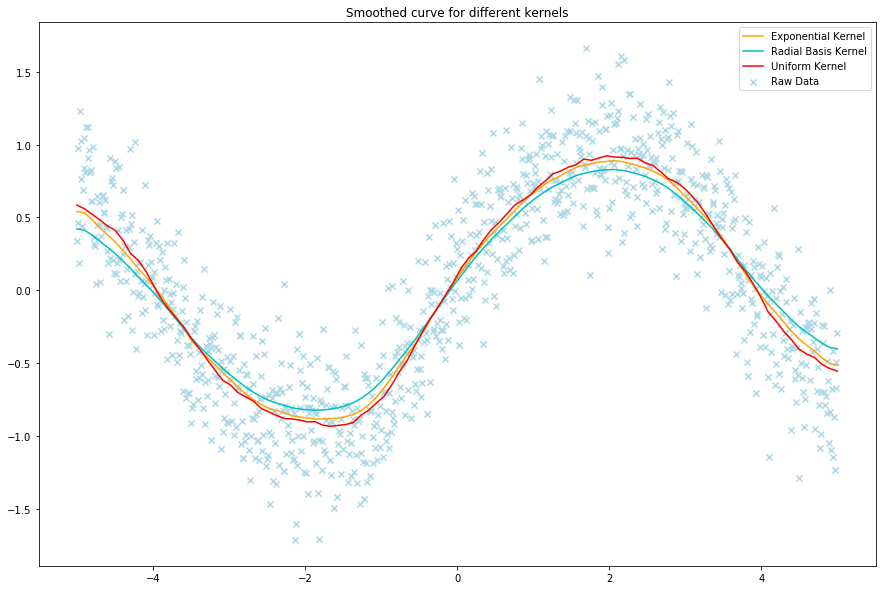

In [61]:
plt.figure(figsize=(15, 10))
plt.scatter(data.x, data.y, marker = 'x', color = 'lightblue', label='Raw Data')
plt.plot(x, [mhx1(x) for x in xx],'orange', label = 'Exponential Kernel')
plt.plot(x, [mhx2(x) for x in xx],'c', label = 'Radial Basis Kernel')
plt.plot(x, [mhx3(x) for x in xx],'red', label = 'Uniform Kernel')
plt.legend(loc='upper right')
plt.title('Smoothed curve for different kernels')
plt.savefig('./img/q2_kernel1.png')

#### Part 3

In [62]:
data2 = pd.read_csv('kernel_regression_2.csv')
X = data2.x.values
Y = data2.y.values
Z = data2.z.values
size = len(data2)

In [65]:
# kernal functions 
k1 = lambda x, y, xp, yp: math.exp(-3*max(abs(x - xp), abs(y - yp)))
k2 = lambda x, y, xp, yp: math.exp(-2*math.sqrt((x - xp)**2 + (y - yp)**2))
k3 = lambda x, y, xp, yp: max(abs(x - xp), abs(y - yp))<0.5

mhx1 = lambda x, y: sum(k1(x, y, X[i], Y[i])*Z[i] for i in range(size))/sum(k1(x, y, X[i], Y[i]) for i in range(size))
mhx2 = lambda x, y: sum(k2(x, y, X[i], Y[i])*Z[i] for i in range(size))/sum(k2(x, y, X[i], Y[i]) for i in range(size))
mhx3 = lambda x, y: sum(k3(x, y, X[i], Y[i])*Z[i] for i in range(size))/sum(k3(x, y, X[i], Y[i]) for i in range(size))

Text(0.5, 0.92, 'Smooth Surface for Exponential Kernel')

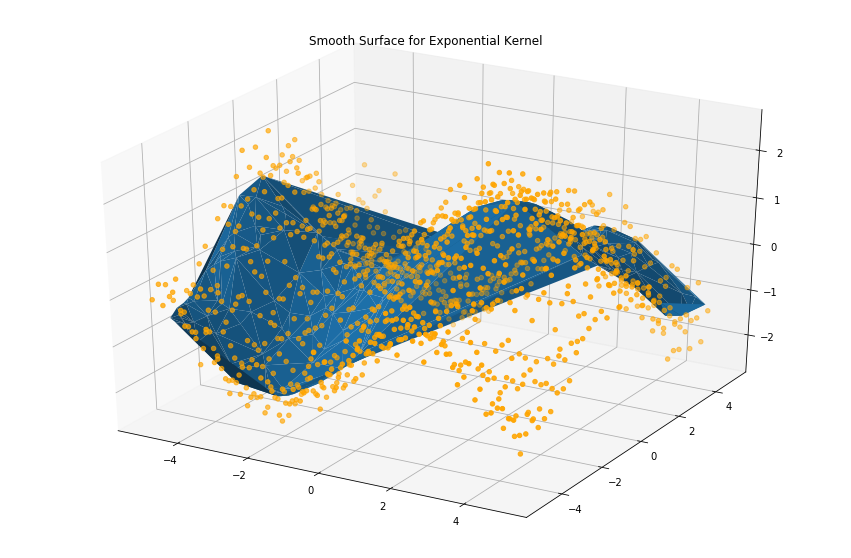

In [68]:
xx = list(np.random.random(n)*5) + list(np.random.random(n)*(-5))
yy = list(np.random.random(n)*5) + list(np.random.random(n)*(-5))
plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection = '3d')
ax.scatter(X, Y, Z, c = 'orange', label = 'RawData')
ax.plot_trisurf(xx, yy, [mhx1(xx[i], yy[i]) for i in range(2*n)], linewidth = 0.1, label='Exponential Kernel')
plt.title('Smooth Surface for Exponential Kernel')
plt.savefig('./img/p2_exp.png')

Text(0.5, 0.92, 'Smooth Surface for Radial Basis Kernel')

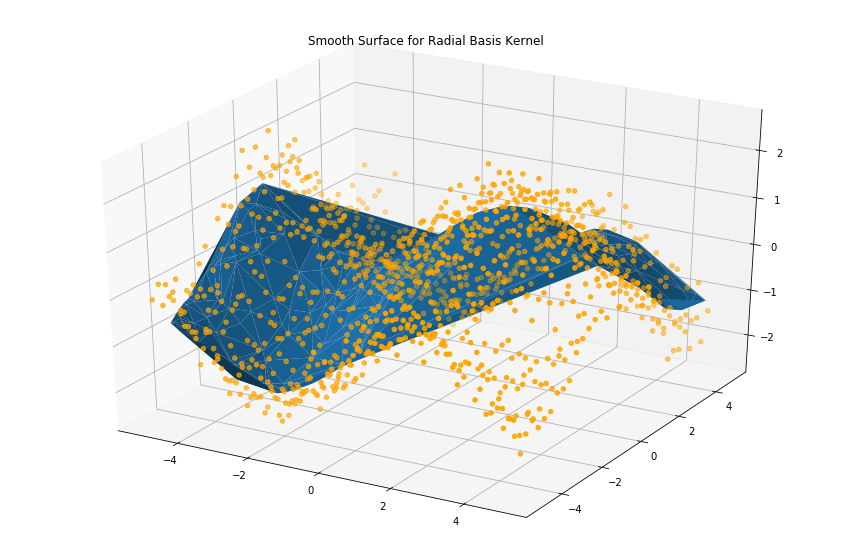

In [69]:
plt.figure(figsize = (15, 10))
ax = plt.subplot(111, projection = '3d')
ax.scatter(X, Y, Z, c = 'orange', label='RawData')
ax.plot_trisurf(xx, yy, [mhx2(xx[i], yy[i]) for i in range(2*n)], linewidth = 0.1, label = 'Radial Basis')
plt.title('Smooth Surface for Radial Basis Kernel')
plt.savefig('./img/p2_rad.png')

Text(0.5, 0.92, 'Smooth Surface for Uniform Kernel')

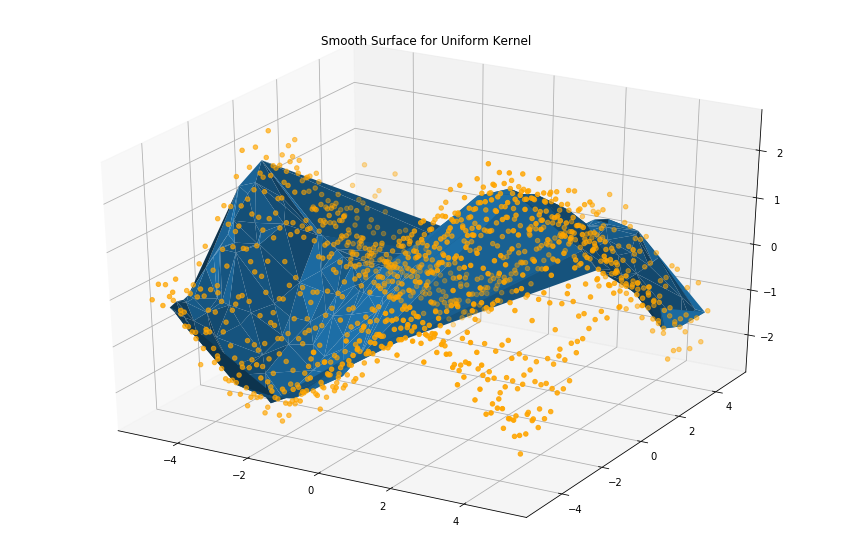

In [70]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection = '3d')
ax.scatter(X, Y, Z, c = 'orange', label = 'RawData')
ax.plot_trisurf(xx, yy, [mhx3(xx[i], yy[i]) for i in range(2*n)], linewidth = 0.1, label = 'Uniform')
plt.title('Smooth Surface for Uniform Kernel')
plt.savefig('./img/p2_uni.png')

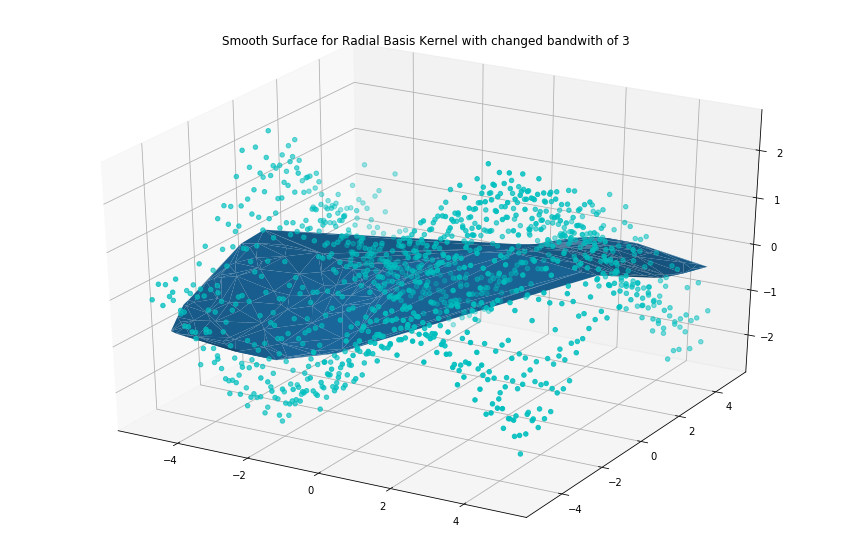

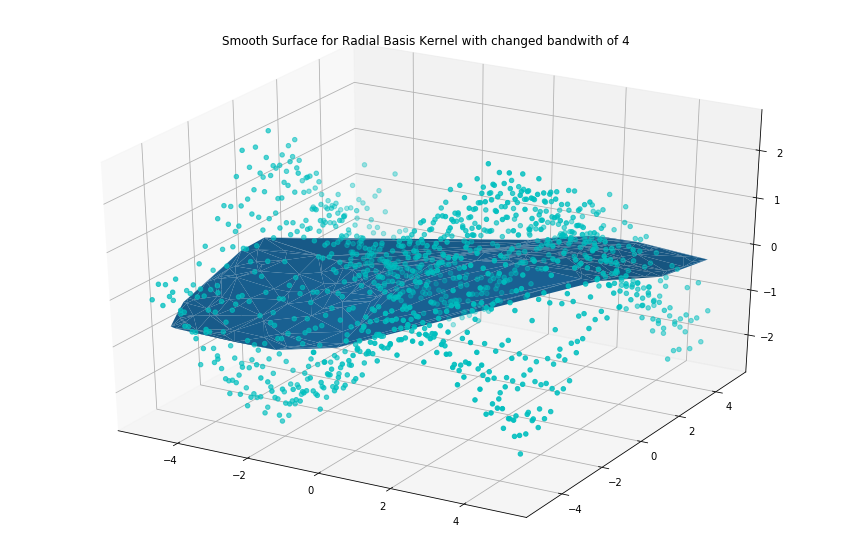

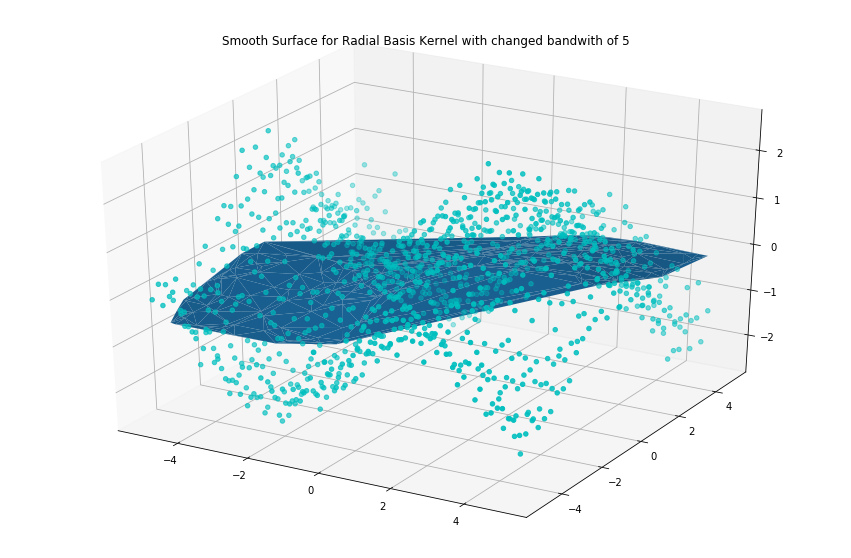

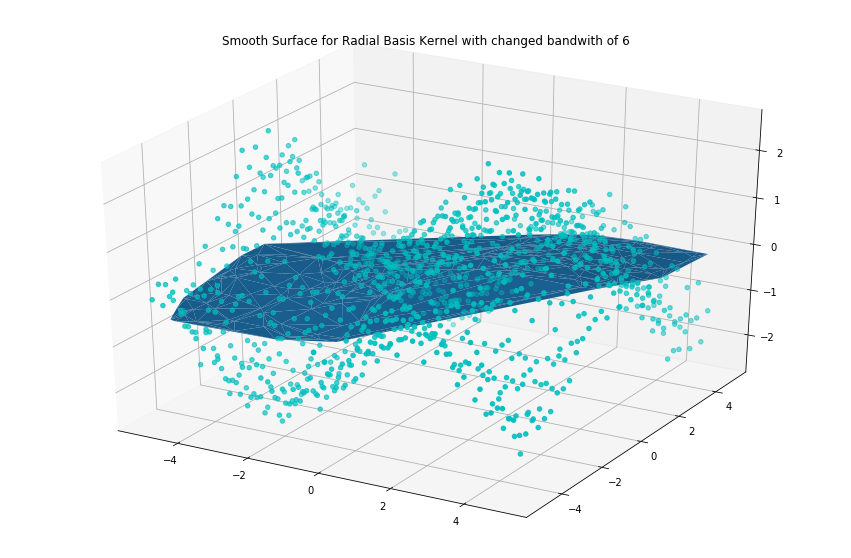

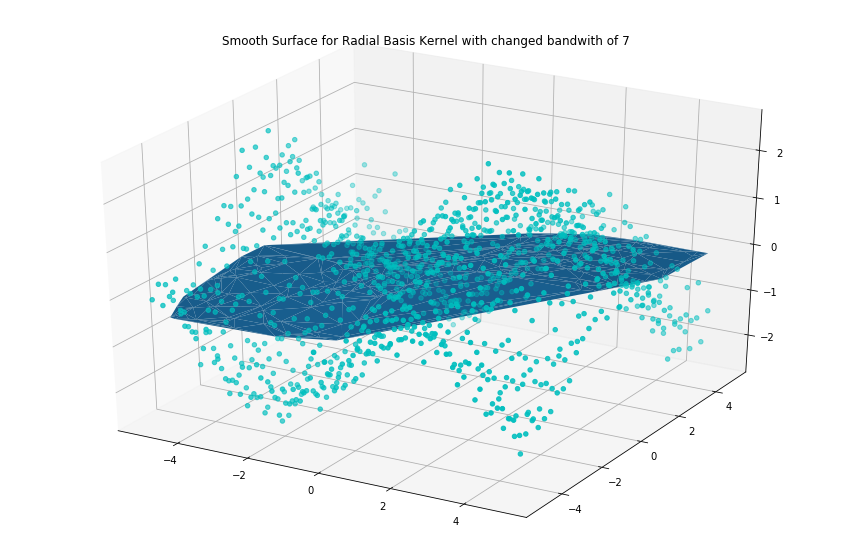

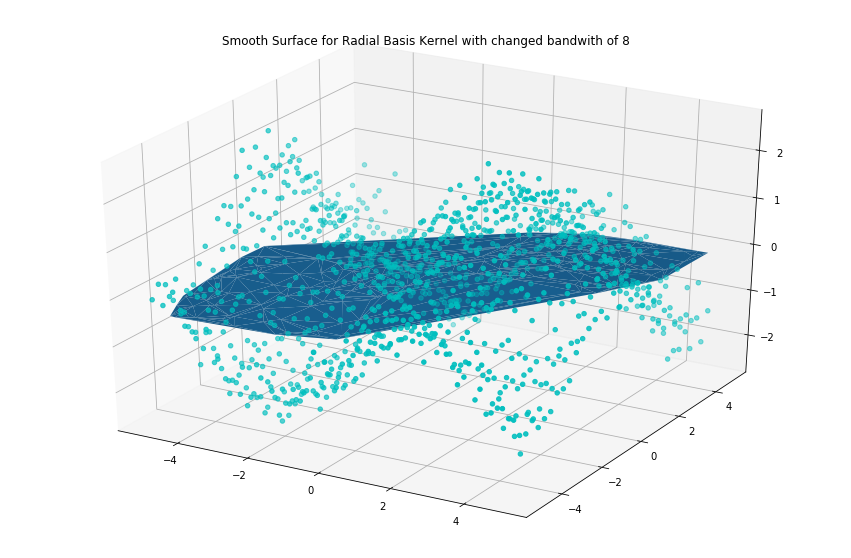

In [71]:
for bandwith in range(3, 9):
    k2 = lambda x, y, xp, yp: math.exp(-2*math.sqrt(((x - xp)/bandwith)**2 + ((y - yp)/bandwith)**2))
    mhx2 = lambda x, y: sum(k2(x, y, X[i], Y[i])*Z[i] for i in range(size))/sum(k2(x, y, X[i], Y[i]) for i in range(size))
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111, projection = '3d')
    ax.scatter(X, Y, Z, c = 'c', label = 'RawData')
    ax.plot_trisurf(xx, yy, [mhx2(xx[i], yy[i]) for i in range(2*n)], linewidth = 0.1, label = 'Radial Basis')
    plt.title('Smooth Surface for Radial Basis Kernel with changed bandwith of ' + str(bandwith))

### Question 3: Programming: Stochastic Subgradient Descent
For this part, we randomly choose samples for gradient computing in order to accelerate the subgradient descent.

In [7]:
data3 = pd.read_csv('svm.csv')
X = data3[['x','intercept']].values
Y = data3['y'].values
label = data3['class'].values

In [12]:
def cost(W, X, Y):
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances > 0] = 1
    hinge_loss = (np.sum(distances) / N)
    return abs(hinge_loss)

def gradient(W, X, Y, ratio):
    index = random.sample(range(0, len(X)), int(len(X)*ratio))
    dw = np.zeros(len(W))
    for i in index :
        if (Y[i]*np.dot(X[i], W)) < 1:
            di = (W - 2*X[i] * Y[i])
        else:
            di = W
        dw += di
    return dw/int(len(X)*ratio)

def eta(i):
    return 1.0/(i*2)

def svm_train(X,Y,ratio):
    w = np.array([-800, 0])
    res = []
    for epoch in range(1, 201):
        w = w - eta(epoch)*gradient(w, X, Y, ratio)
        loss = cost(w, X, Y)
        res.append([epoch, w, loss])
    return w, res

w, res = svm_train(X, Y, 0.7)

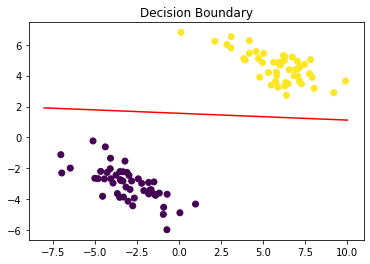

In [13]:
x_vals = np.linspace(-8,10,100)
y_vals = w[1] + w[0] * x_vals
plt.plot(x_vals, y_vals, '-', color = 'red')
plt.scatter(X[:,0], Y, c = label)
plt.title('Decision Boundary')
plt.savefig('./img/p3_linear_sep_bound.png')

Text(0.5, 1.0, 'Loss VS Time')

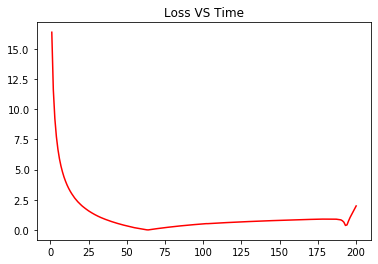

In [14]:
res = np.array(res)
plt.plot(res[:,0], res[:,2], '-', color = 'red')
plt.title('Loss VS Time')
plt.savefig('./img/p3_loss_over_time.png')

Text(0.5, 1.0, "Run Time for Different 'n'")

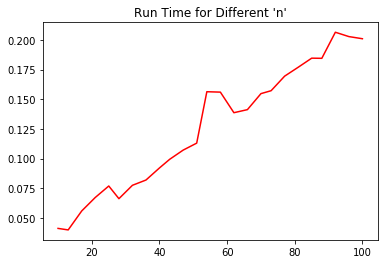

In [82]:
run_time=[]
for i in np.linspace(0.1, 1.0, 25):
    start = time.time()
    _, _ = svm_train(X, Y, i)
    end = time.time()
    run_time.append([int(i*len(X)), end - start])

run_time = np.array(run_time)
plt.plot(run_time[:,0], run_time[:,1], '-', color = 'red')
plt.title('Run Time for Different \'n\'')
plt.savefig('./img/p3_runtime_diff.png')

### Question 7: Programming a Gibbs Sampler

In [4]:
data4 = pd.read_csv('gibbs.csv')
size = len(data4.value)
alpha, beta = 30, 4
lam = np.random.gamma(sum(data4.value) + alpha, beta/(size*beta + 1), 1000)

In [5]:
def likelihood(lam, data):
    res = 1
    for v in data.value:
        res *= stats.poisson.pmf(v, lam)
    return -math.log(res)

Text(0.5, 1.0, 'Likelihood Function Value for Different lambda')

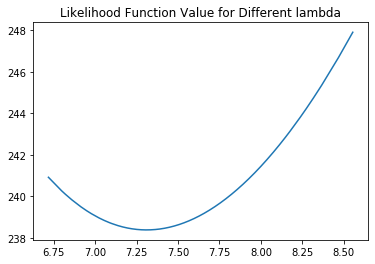

In [7]:
lam.sort()
plt.plot(lam, [likelihood(l, data4) for l in lam])
plt.title('Likelihood Function Value for Different lambda')
plt.savefig('./img/p7_likelihood.png')

Text(0.5, 1.0, 'Posterior Distribution for lambda')

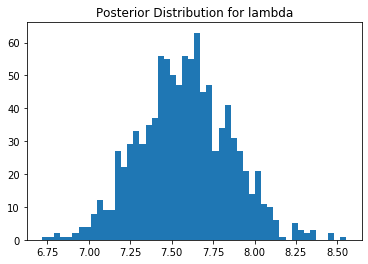

In [9]:
plt.hist(lam, bins = 50)
plt.title('Posterior Distribution for lambda')
plt.savefig('./img/p7_post_dist.png')

Text(0.5, 1.0, 'Posterior Predictive Distribution')

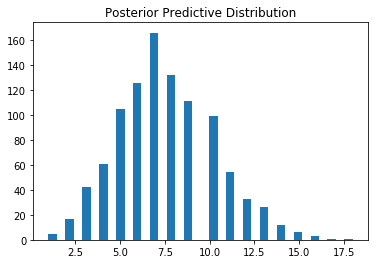

In [91]:
plt.hist(np.random.poisson(sum(lam)/len(lam), 1000), bins = 36)
plt.title('Posterior Predictive Distribution')
plt.savefig('./img/p7_post_predict.png')

### Question 8: Change Points Models

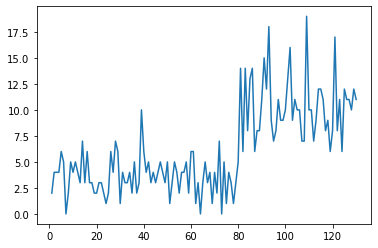

In [16]:
data5 = pd.read_csv('change_point1.csv')
plt.plot(data5['x'], data5['y'])
plt.savefig('./img/p8_change_pt.png')

In [18]:
from theano import tensor as T
niter = 2000 #number of iterations for the MCMC algorithm
size = len(data5)
t = np.arange(0, size) #array of observation positions ('time')
data = data5['y'].values

with pm.Model() as model:
    # define exponential prior
    alpha=pm.Exponential('alpha',1/np.mean(data))
    beta=pm.Exponential('beta',1/np.mean(data))
    tau=pm.DiscreteUniform("tau",t.min(),t.max())
    lambda_=T.switch(tau>=t, alpha, beta)
    ## note that the factorial constant is ignored
    logp = -lambda_ + T.log(lambda_)*data
    
    def logp_func(data):
        return logp.sum()
    
    L_obs=pm.DensityDist('L_obs',logp_func, observed=data)
    #start MCMC algorithm
    start = pm.find_MAP()
    #iterate MCMC
    trace = pm.sample(niter, start=start, random_seed=123, progressbar=True)

logp = 615.43, ||grad|| = 292.24: 100%|██████████| 9/9 [00:00<00:00, 103.37it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [beta, alpha]
>Metropolis: [tau]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:36<00:00, 51.67draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied val

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d0262b0>,
      dtype=object)

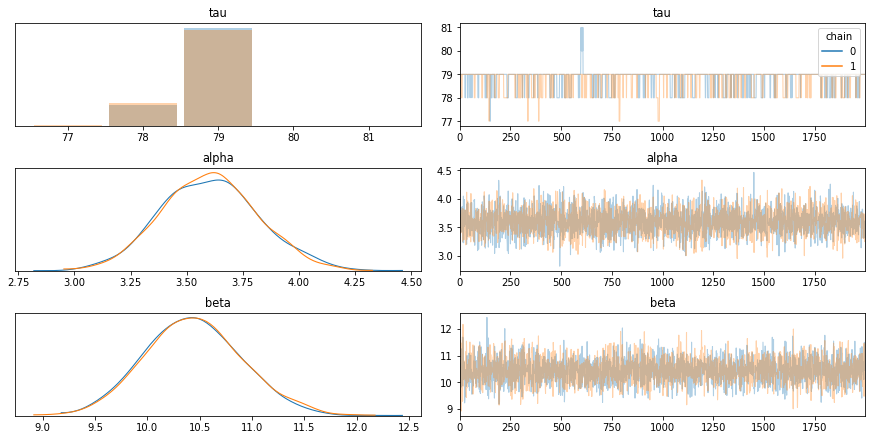

In [19]:
pm.traceplot(trace,legend=True)

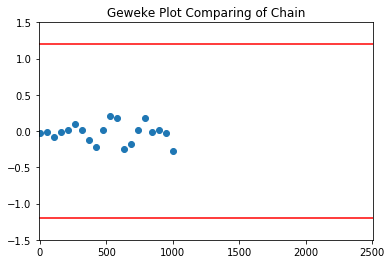

In [21]:
gw_plot = pm.geweke(trace.get_values(varname='tau', chains=0))
plt.scatter(gw_plot[:,0], gw_plot[:,1])
plt.axhline(-1.2, c = 'r')
plt.axhline(1.2, c = 'r')
plt.ylim(-1.5,1.5)
plt.title('Geweke Plot Comparing of Chain')
plt.xlim(-10, 2510)
plt.savefig('./img/p8_geweke.png')

### Question 9: Programming a Hierarchical Model using Pymc3

In [22]:
data6 = pd.read_csv('radon.csv')
srrs2 = pd.read_csv(get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [23]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

In [24]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

In [25]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

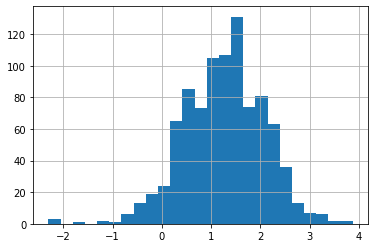

In [26]:
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25);

### Multilevel and Hierarchical Models

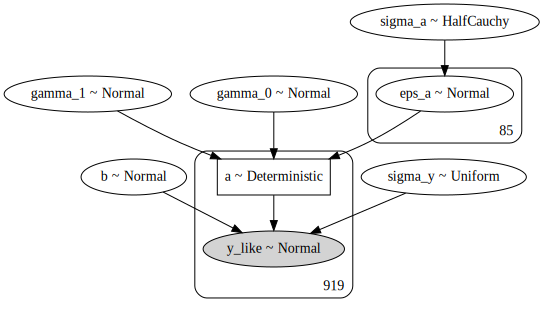

In [27]:
with Model() as hierarchical_intercept:
    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)
    
    # County uranium model for slope
    gamma_0 = Normal('gamma_0', mu=0., sigma=1e5)
    gamma_1 = Normal('gamma_1', mu=0., sigma=1e5)
    # Uranium model for intercept
    mu_a = gamma_0 + gamma_1*u
    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sigma=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])
    
    # Common slope
    b = Normal('b', mu=0., sigma=1e5)
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)
    
model_to_graphviz(hierarchical_intercept)

In [28]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, b, eps_a, gamma_1, gamma_0, sigma_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [2:21:58<00:00,  2.13s/draws]  
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied val

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12effb860>,
      dtype=object)

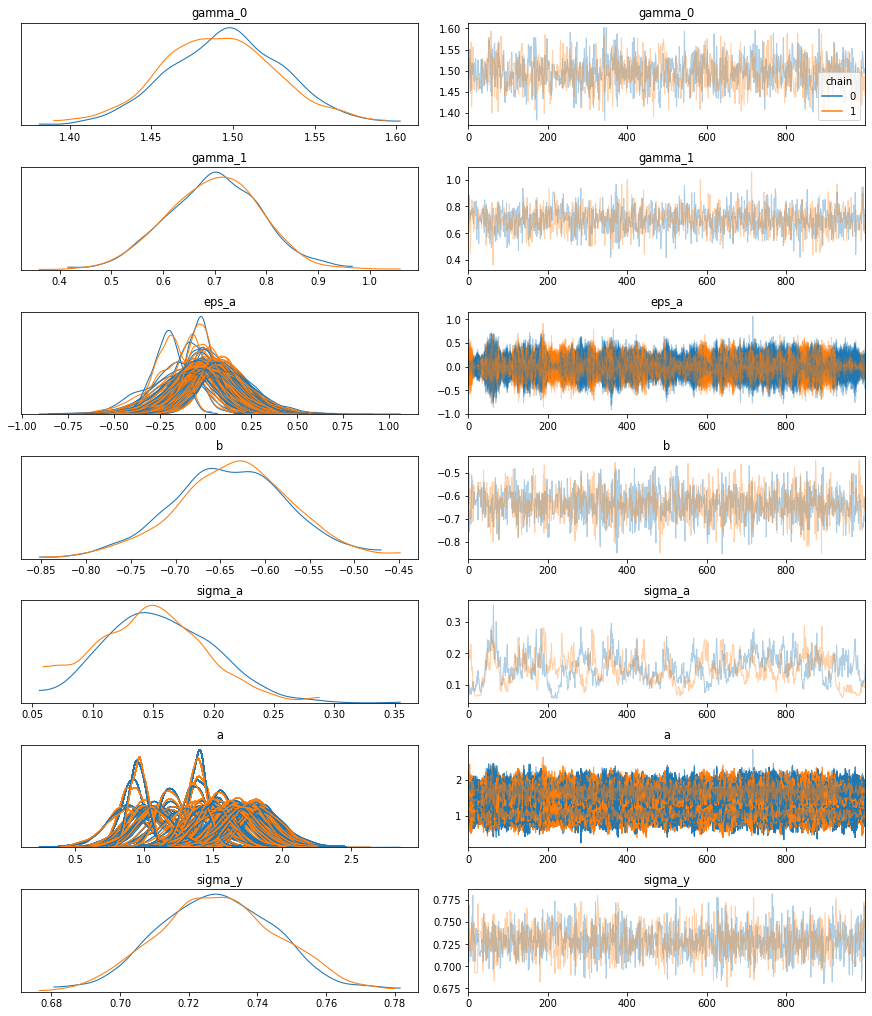

In [29]:
pm.traceplot(hierarchical_intercept_trace,legend=True)

In [32]:
a_means = hierarchical_intercept_trace['a'].mean(axis=0)
b_means = hierarchical_intercept_trace['b'].mean(axis=0)
y_hat = a_means + b_means * floor_measure
srrs_mn['log_radon_predict']=y_hat

In [33]:
data = srrs_mn[['county','log_radon','log_radon_predict']].groupby('county').mean().reset_index()

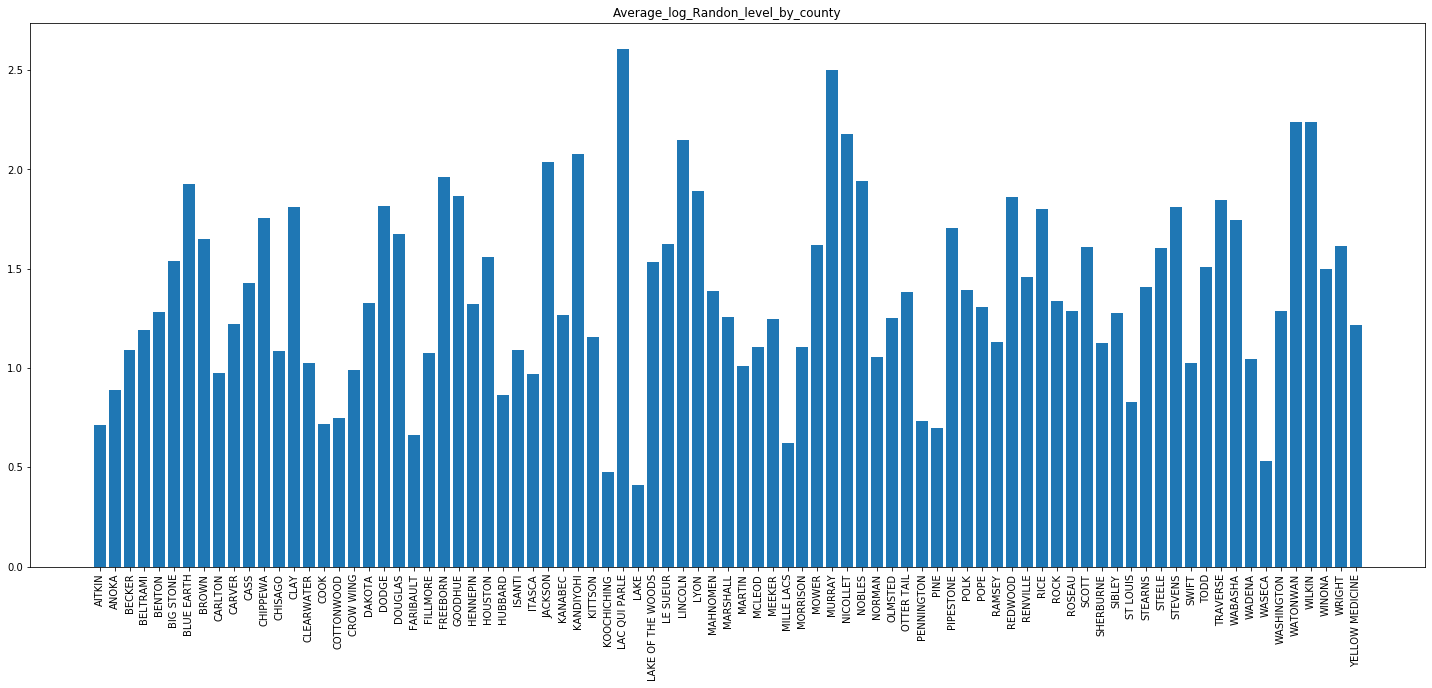

In [34]:
plt.figure(figsize=(25, 10))
plt.bar(data['county'], data['log_radon'])
plt.xticks(rotation = 'vertical')
plt.title('Average_log_Randon_level_by_county')
plt.savefig('./img/p9_avg_log_random.png')

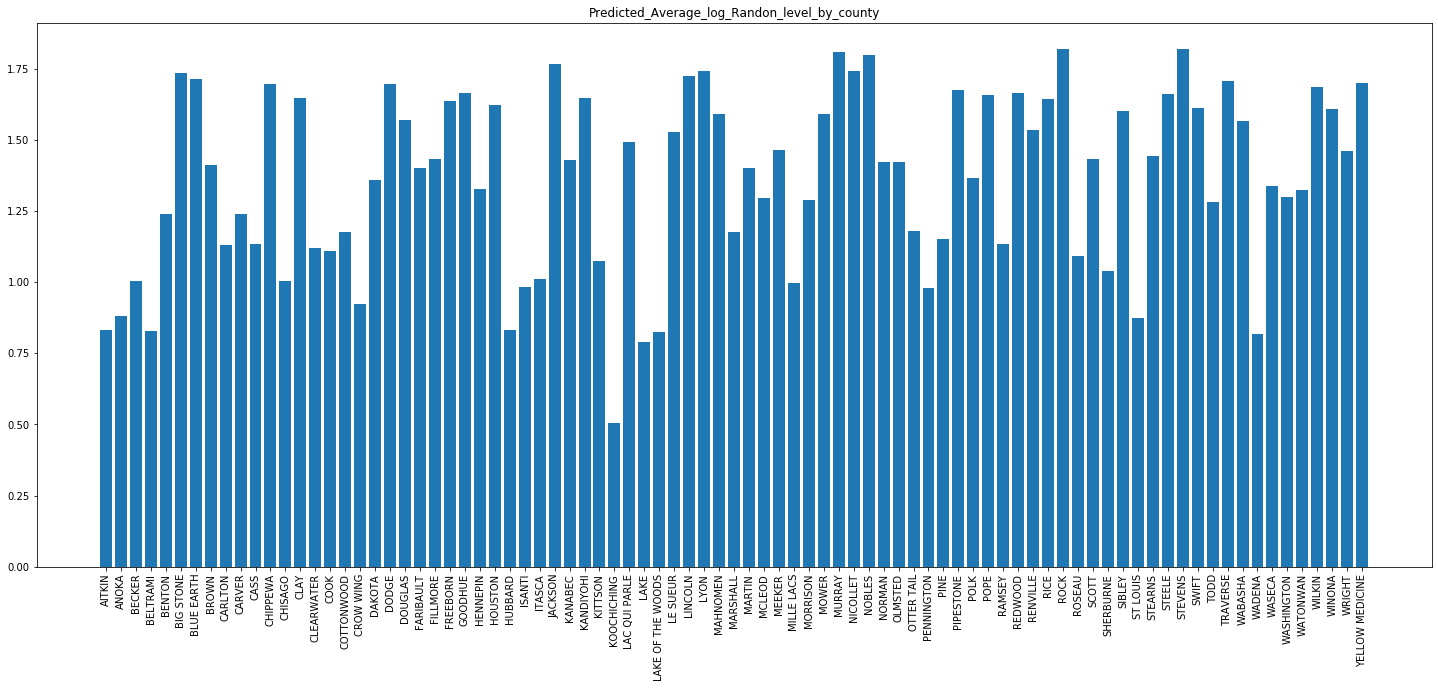

In [35]:
plt.figure(figsize=(25, 10))
plt.bar(data['county'], data['log_radon_predict'])
plt.xticks(rotation = 'vertical')
plt.title('Predicted_Average_log_Randon_level_by_county')
plt.savefig('./img/p9_predict_avg.png')